<h1><center>2122ADXC - Complex Network Analysis</center></h4>
<h2><center>Term Project</center></h2>
<h3><center>Prepared By: Mert Mecit</center></h3>
   

In this assignment, my aim is to use a dataset to perform various analyses in complex network analysis context.

<h3>1) Data Introduction & Preparation</h3>

Data I will be using throughout the project is called "USA Airport Dataset" in <a href="https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset"> Kaggle</a>. It has more than 3.5 million records of domestic flights in the USA from 1990 to 2009.

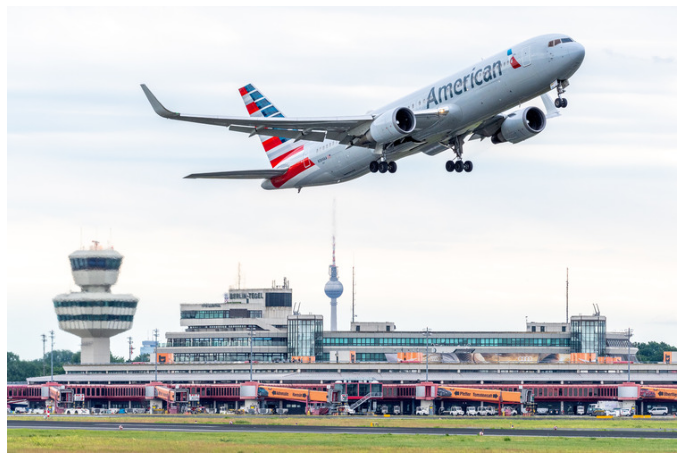

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
img = mpimg.imread('American-TXL-PHL.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Before showing dataset, I will import my libraries that I use throughout the project.

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools

Now let's have a look at the original dataset. It consists of rows that contain:
<ul>
    <li>Origin and Destination Airport Names: Our dataset contains <b>origin aiport</b> and <b>destination airport names</b>, both 3 letter abbreviations.</li>
    <li>Origin and Destination Cities: Our dataset contains <b>origin aiport</b> and <b>destination airport cities</b>.</li>
    <li>Total <b>passengers</b> that used the road, total available <b> seats </b>, total <b> flights </b> in a month as this data is monthly, total <b> distance </b>, <b> fly_date </b> for the year and month and <b> population of both origin and destination cities.</b> </li>
    <li><b>Latitude</b> and <b>longitude</b> values for both original and destination airports. </li>
</ul>

In [3]:
original_df = pd.read_csv("Airports.csv")
original_df.sample(5, random_state=123)

Origin_airport Destination_airport        Origin_city  \
159512             EKO                 TUL           Elko, NV   
1371154            SFO                 PHX  San Francisco, CA   
1747255            PHL                 LGA   Philadelphia, PA   
2238743            IAH                 MKE        Houston, TX   
2716643            SFO                 SMF  San Francisco, CA   

        Destination_city  Passengers  Seats  Flights  Distance    Fly_date  \
159512         Tulsa, OK         104    122        1      1122  1999-05-01   
1371154      Phoenix, AZ       10570  14588      135       651  1997-08-01   
1747255     New York, NY        1103   2950       59        96  2005-12-01   
2238743    Milwaukee, WI        2199   2884       28       984  1999-04-01   
2716643   Sacramento, CA         471   4402       31        85  1990-01-01   

         Origin_population  Destination_population  Org_airport_lat  \
159512               47319                  841453        40.824902   
1371154            7885792                 2841395        37.618999   
1747255           11701242                37596228        39.871899   
2238743            4540138                 1462422        29.984400   
2716643            7436126                 1520816        37.618999   

         Org_airport_long  Dest_airport_lat  Dest_airport_long  
159512        -115.792000         36.198399         -95.888100  
1371154       -122.375000         33.434299        -112.012001  
1747255        -75.241096         40.777199         -73.872597  
2238743        -95.341400         42.947201         -87.896599  
2716643       -122.375000         38.695400        -121.591003

There are quite more information then we need. So, we need to adjust the data to our needs.
<ul>
    <li>We only needs columns of origin and destination airport, total passengers, fly date and 4 location information. All null values are dropped then.</li>
    <li>As dataset is relatively huge, I selected flights only on the year 2000.</li>
    <li>After selecting specific yers, I dropped fly_date as well. Then we needed to add all of the passengers in one year to find total passengers in a year. I used a groupby function to do so.</li>
    <li>Finally, I deleted every row that has passengers value as 0 because there were some flights scheduled but nobody took the flight.</li>
</ul>

In [4]:
original_df = original_df[original_df["Origin_airport"]!=original_df["Destination_airport"]]

df = original_df[["Origin_airport","Destination_airport","Passengers","Fly_date","Org_airport_lat","Org_airport_long","Dest_airport_lat","Dest_airport_long"]]
df.dropna()

searchfor = ['2000']
df = df[df['Fly_date'].str.contains('|'.join(searchfor))]

df = df.reset_index(drop=True)
df.drop(columns=["Fly_date"])

df = df.groupby(['Origin_airport','Destination_airport',"Org_airport_lat","Org_airport_long","Dest_airport_lat","Dest_airport_long"], as_index=False)['Passengers'].sum()

df = df[df['Passengers']!=0]

As you can see below, we have approx. 290 different airports (nodes) and 7348 flight routes (edges)

In [5]:
df.describe()

Org_airport_lat  Org_airport_long  Dest_airport_lat  Dest_airport_long  \
count      7331.000000       7331.000000       7331.000000        7331.000000   
mean         37.683263        -91.937724         37.601567         -91.857275   
std           5.553141         15.547220          5.554569          14.499909   
min          19.721399       -157.921997         19.721399        -157.921997   
25%          33.636700        -97.433098         33.434299         -97.230499   
50%          38.805801        -87.904800         38.748699         -88.591400   
75%          41.732601        -80.943100         41.708698         -81.593201   
max          64.815102        -68.828102         64.837502         -68.828102   

         Passengers  
count  7.331000e+03  
mean   7.280650e+04  
std    1.535014e+05  
min    1.000000e+00  
25%    1.080000e+02  
50%    1.862000e+03  
75%    7.625650e+04  
max    1.922436e+06

In [6]:
df.nunique()

Origin_airport          289
Destination_airport     286
Org_airport_lat         289
Org_airport_long        289
Dest_airport_lat        286
Dest_airport_long       286
Passengers             4368
dtype: int64

<h3>2) Network Creation & Visualization</h3>

Now we have our data, we can visualize it. First, I create my network as <b>"network"</b> from my pandas dataframe.

In [7]:
network = nx.from_pandas_edgelist(df, "Origin_airport","Destination_airport",["Passengers"])

First, I will draw the network with the simplest way possible.

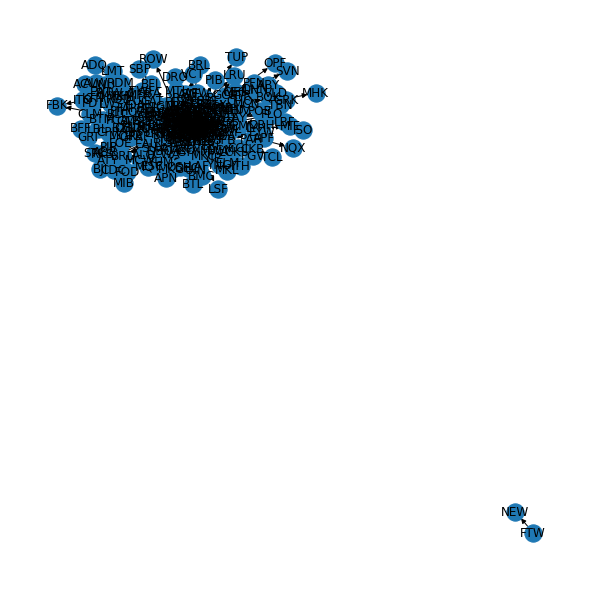

In [8]:
plt.figure(figsize=(8,8))
my_pos = nx.spring_layout(network, seed = 100)
nx.draw(network, with_labels=True, arrows=True, pos = my_pos)
plt.show()

As they are relatively insignificant and can cause some problems, we drop those two airports.

In [9]:
df = df[df['Origin_airport']!="NFW"]
df = df[df['Destination_airport']!="NFW"]
df = df[df['Origin_airport']!="FTW"]
df = df[df['Destination_airport']!="FTW"]

As you can see, this looks very ugly as there is a big community here that we can read nothing on and there are very distant two nodes. We can try to draw it better.

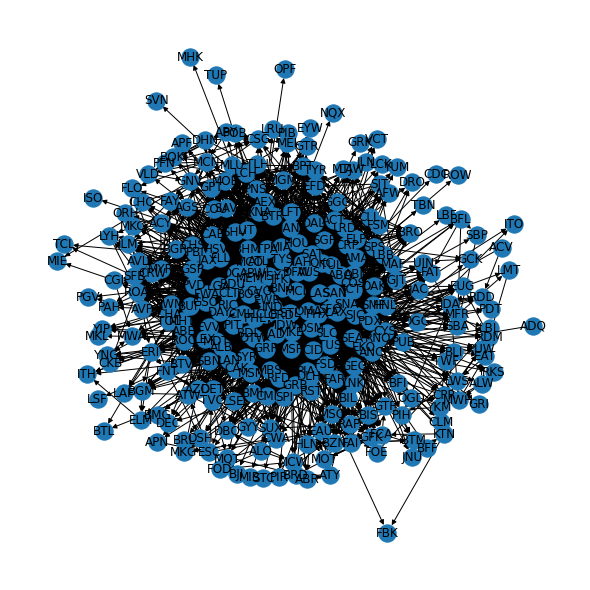

In [10]:
network = nx.from_pandas_edgelist(df, "Origin_airport","Destination_airport",["Passengers"])

plt.figure(3,figsize=(8,8)) 
nx.draw_kamada_kawai(network, with_labels=True, arrows=True)
plt.show()

This looks better. However, still the close nodes does mean nothing here when we think. TCL (in Alabama) and MIE (in Delaware) are far away from each other, yet in the graph, they look close. We can get rid of this problem by assigning position values.

For this purpose, first I create a position dictionary that takes longitude and latitude values for each airport in our dataset.

In [11]:
position_dict = {}
for index, row in df.iterrows():
    position_dict[row["Origin_airport"]] = (row["Org_airport_long"],row["Org_airport_lat"])
    position_dict[row["Destination_airport"]] = (row["Dest_airport_long"],row["Dest_airport_lat"])

In [12]:
import random

random.seed(123)
random.sample(position_dict.items(), 5)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9224\1664778850.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(position_dict.items(), 5)


[('ABQ', (-106.609001159668, 35.0401992797852)),
 ('BFI', (-122.302001953125, 47.5299987792969)),
 ('COS', (-104.70099639893, 38.805801391602)),
 ('ISO', (-77.6088027954, 35.331401825)),
 ('YKM', (-120.5439987, 46.56819916))]

Then, when we redraw our network with using those positions, we get:

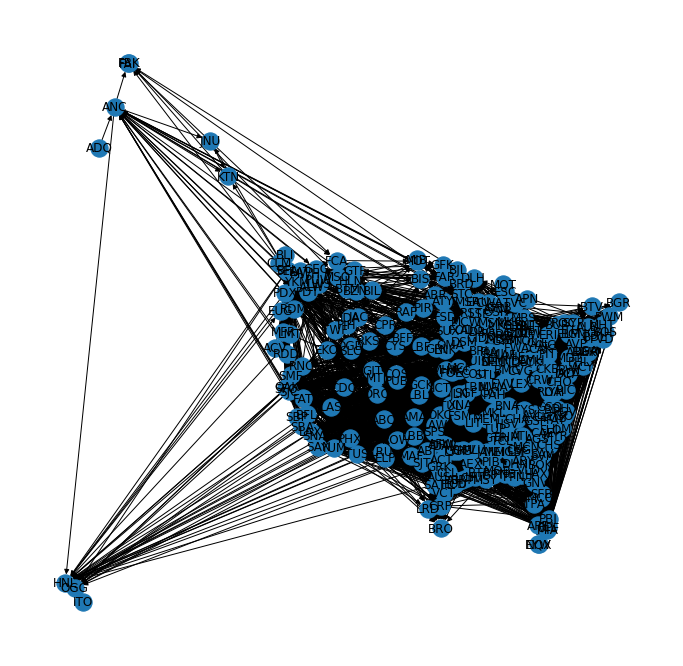

In [13]:
plt.subplots(figsize=(12,12))
nx.draw(network, with_labels=True, arrows=True, pos=position_dict)
plt.show()

This is much better. To see them on an actual USA map, I created the image below. 

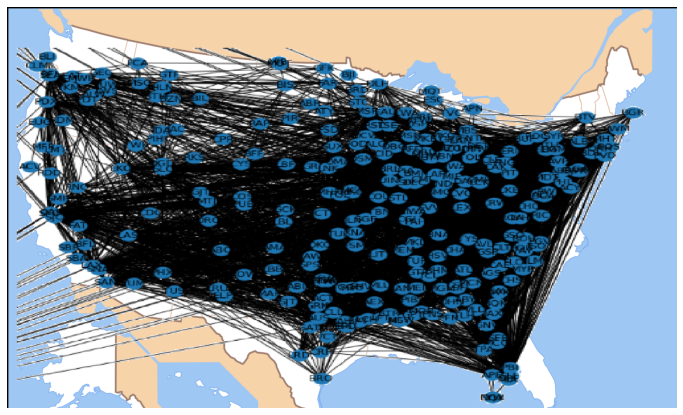

In [14]:
plt.subplots(figsize=(12,12))
im = plt.imread("map_airlines.png")
plt.axis('off')
implot = plt.imshow(im)

Now our dataset and drawing is ready, we can move to our analyses.

<h3>3) Analyses</h3>

<h4>a) Microscale</h4>

Here, we will have a look at role of nodes in the network with a microscale approach. 

<h5>i) Degree</h5>

First, we can have a look at degrees of each node (airport).

In [15]:
degrees = {node:val for (node, val) in network.degree()}
degrees = pd.DataFrame.from_dict(degrees, orient="index")
degrees.columns = ['degrees']
degrees_ = degrees.sort_values('degrees', ascending=False)
degrees_.head(5)

degrees
MSP      145
ATL      143
DFW      143
ORD      142
STL      128

As you can see, we have several airports that have very high degrees. They indicate total number of links a node has. For comparison, here I add how they rank in total domestic flights in 2000. <a href="https://en.wikipedia.org/wiki/List_of_busiest_airports_by_passenger_traffic_(2000%E2%80%932009)#2000_statistics"> Source </a>

<table>
  <tr>
    <th>Airport</th>
    <th>Ranking in Degrees</th>
  </tr>
  <tr>
    <td>Atlanta (ATL)</td>
    <td>3</td>
  </tr>
  <tr>
    <td>Chicago (ORD)</td>
    <td>4</td>
  </tr>
  <tr>
    <td>Los Angeles (LAX)</td>
    <td>15</td>
  </tr>
  <tr>
    <td>Dallas (DFW)</td>
    <td>2</td>
  </tr>
  <tr>
    <td>Denver (DEN)</td>
    <td>+50</td>
  </tr>
  <tr>
    <td>New York (JFK)</td>
    <td>32</td>
  </tr>
  <tr>
    <td>Las Vegas (LAS)</td>
    <td>24</td>
  </tr>
</table>

In [16]:
degrees = {node:val for (node, val) in network.degree()}
degrees = pd.DataFrame.from_dict(degrees, orient="index")
degrees.columns = ['degrees']
degrees['Origin_airport'] = degrees.index
degree_pd = pd.merge(degrees,df,on="Origin_airport",how="left")
degree_pd = degree_pd.drop(columns=["Destination_airport","Org_airport_lat","Org_airport_long","Dest_airport_lat","Dest_airport_long","Passengers"])
degree_pd = degree_pd.drop_duplicates()
degree_pd.reset_index(drop=True)
degree_pd['degrees_over_100'] = np.where(degree_pd['degrees']>=100, 1, 0)
degree_pd.head()

degrees Origin_airport  degrees_over_100
0         44            ABE                 0
24       143            ATL                 1
167       23            AVP                 0
184       90            BWI                 0
267       48            CHS                 0

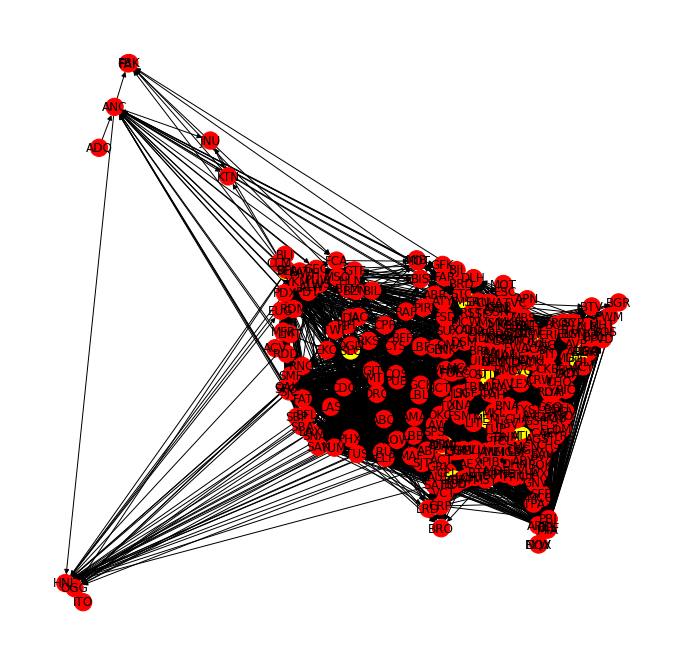

In [17]:
plt.subplots(figsize=(12,12))
color_map = []
for column in degree_pd["degrees_over_100"]:
    if column == 0:
        color_map.append('red')
    else: 
        color_map.append('yellow')      
nx.draw(network, with_labels=True, arrows=True, pos=position_dict, node_color = color_map)
plt.show()

As you can see we have several yellow airlines above that have +100 degrees. To compare, I also added heatmap of 2000 domestic US flights below.

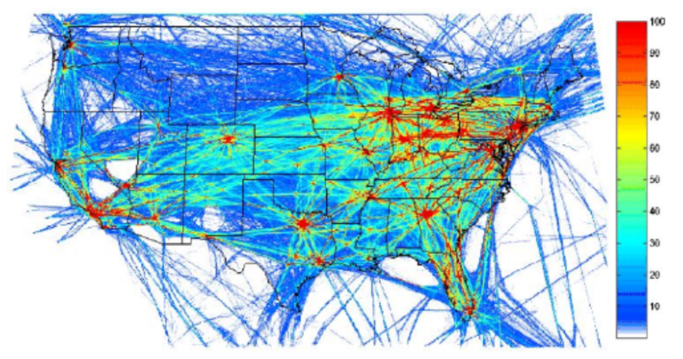

In [18]:
plt.figure(figsize=(12,12))
img = mpimg.imread('us_heatmap.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

As you can see, both our map and the actual map have most important nodes more one east coast of the US.

<h5>ii) Centralities</h5>

In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Here, we will have a look at 4 different centralities:
<ul>
    <li>Degree Centrality: Simplest one, number of links incident upon a node.</li>
    <li>Closeness Centrality: Average length of the shortest path between the node and all other nodes.</li>
    <li>Betweenness Centrality: Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.</li>
    <li>Eigenvector Centrality: It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.</li>
</ul>

In [19]:
dc = nx.degree_centrality(network)
dc = pd.DataFrame.from_dict(dc, orient='index')
dc.rename(columns = {0:'d_cent'}, inplace = True)
dc = dc.sort_values("d_cent", ascending=False)

cc = nx.closeness_centrality(network)
cc = pd.DataFrame.from_dict(cc, orient='index')
cc.rename(columns = {0:'c_cent'}, inplace = True)
cc = cc.sort_values("c_cent", ascending=False)

bc = nx.betweenness_centrality(network)
bc = pd.DataFrame.from_dict(bc, orient='index')
bc.rename(columns = {0:'b_cent'}, inplace = True)
bc = bc.sort_values("b_cent", ascending=False)

ec = nx.eigenvector_centrality(network)
ec = pd.DataFrame.from_dict(ec, orient='index')
ec.rename(columns = {0:'e_cent'}, inplace = True)
ec = ec.sort_values("e_cent", ascending=False)

The function below is for displaying purposes.

In [20]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9224\1850147235.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [21]:
display_side_by_side([dc.head(10), cc.head(10), bc.head(10), ec.head(10)], ['Degree', 'Closeness', 'Betweenness','Eigenvector'])

They all have similar rankings. We can somewhat conclude that, in this dataset, the most central airports are MSP (Minneapolis), DFW (Dallas), ATL (Atlanta) and ORD (Chicago).

<h4>b) Macroscale</h4>

Here, we will have a look at the network as a whole with a macroscale approach.

<h5> i. Distances</h5>

First, we will start with two basic indicators of macroscale, mean shortest path and diameter.

In [22]:
nx.average_shortest_path_length(network)

2.203340890108579

In [23]:
nx.diameter(network)

5

They mean that, it takes 2.2 node to reach from one node to another in this network on average and the largest distance between a pair of nodes is 5.

The code below is from <a href="https://stackoverflow.com/questions/64732486/networkx-diameter-gives-13-want-to-find-what-are-those-nodes-or-distance"> stackoverflow </a> and is used to get the nodes that constitute the diameter.

In [24]:
def get_furthest_nodes(G):
    sp_length = {}
    diameter = None 
    furthest_node_list = [] 
    
    for node in G.nodes:
        
        sp_length[node] = nx.single_source_shortest_path_length(G,node)
        longest_path = max(sp_length[node].values()) 
        
        if diameter == None:
            diameter = longest_path 
        if longest_path >= diameter:
            diameter = longest_path
            node_longest_paths = [(node,other_node)
                                      for other_node in sp_length[node].keys()
                                      if sp_length[node][other_node] == longest_path]
            if longest_path > diameter:
                furthest_node_list = node_longest_paths
            else:   
                furthest_node_list = furthest_node_list + node_longest_paths
                
    return({'diameter':diameter,
            'furthest_node_list':furthest_node_list,
            'node_shortest_path_dicts':sp_length})

The longest shortest path is between MHK (Kansas) and FBK (Alaska) airports. It is understandable because Alaska is far away from Kansas, however there are much more distant airports.

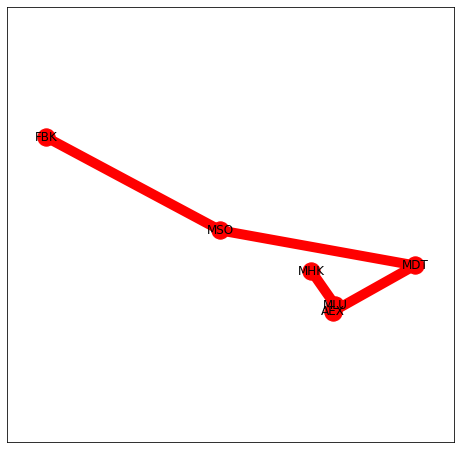

In [25]:
path = nx.shortest_path(network,source="MHK",target="FBK")
path_edges = list(zip(path,path[1:]))
labels = {}
labels["MHK"] = "MHK"
labels["MLU"] = "MLU"
labels["AEX"] = "AEX"
labels["MDT"] = "MDT"
labels["MSO"] = "MSO"
labels["FBK"] = "FBK"

plt.figure(3,figsize=(8,8)) 
nx.draw_networkx_nodes(network,pos=position_dict,nodelist=path,node_color='r')
nx.draw_networkx_edges(network,pos=position_dict,edgelist=path_edges,edge_color='r',width=10)
nx.draw_networkx_labels(network,pos=position_dict, labels=labels, font_size=12,font_family='sans-serif')
plt.axis('equal')
plt.show()

This means, instead of going a direct flight from Alaska (FBK) to Kansas (MHK) (app. <b>4720 km</b>), you should go Alaska (FBK) -> Montana (MSO) (app. 3980 km), Montana (MSO) -> Pennsylvania (MDT) (app. 2700 km), Pennsylvania (MDT) -> Louisiana (AEX) (app. 2090 km), Louisiana (AEX) -> Louisiana (MLU) (app. 160 km) and Louisiana (MLU) -> Kansas (MHK) (app. 1375 km), so a total of <b>8505 km's!</b>

<h5> ii. Clustering</h5>

Here, we would like to see cycles. We would like to see transitivity, fraction of all possible triangles in our network.

In [26]:
nx.transitivity(network)

0.5047066157071887

High transitivity means that the network contains communities or groups of nodes that are densely connected internally. This 0.5 means that chance that two airports have a common link for another airport is almost 50%.

<h5> iii. Degree Distributions</h5>

Degree distribution is the probability distribution of these degrees over the whole network. Source code is <a href="https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html"> here </a>

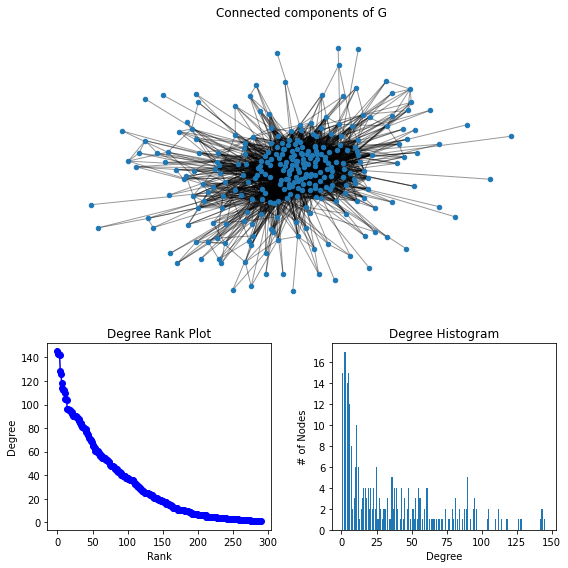

In [27]:
degree_sequence = sorted((d for n, d in network.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = network.subgraph(sorted(nx.connected_components(network), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree Histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

We can see they are highly asymmetric, many have low degrees and a small but significant (vital few) have extraordinary high degrees.

We can also check log-log scale degree distribution.

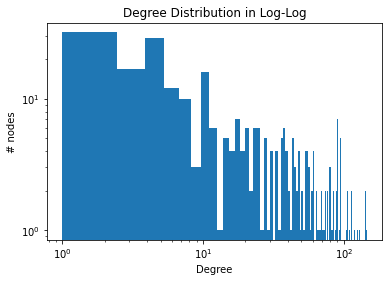

In [28]:
degrees = dict(network.degree()).values() 
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree Distribution in Log-Log')
plt.xscale('log')
plt.yscale('log')
plt.show()

We can also see there the network is highly asymmetric.

<h5> iv. Assortativity</h5>

Assortativity is a preference for a network's nodes to attach to others that are similar in some way.

In [29]:
nx.degree_assortativity_coefficient(network)

-0.06996660199430574

This means that in this network, assortivity is very low but large-degree nodes tend to attach low-degree nodes instead of similar degrees connecting to each other.

<h4>c) Mesoscale</h4>

Here our aim is somewhere between micro and macroscale, detecting communities.

<h5> i. Clique Detection</h5>

A clique in this context is a community of airlines where all of the airlines have direct flights to all the other members in the community. I calculate maximum clique with the following:

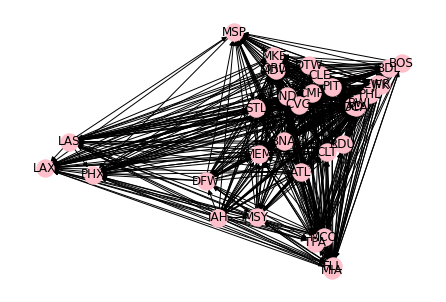

In [30]:
cliques = nx.find_cliques(network)
cliques = sorted(cliques, key=lambda item: -len(item))
max_clique = cliques[0]
h = network.subgraph(max_clique)
nx.draw(h, with_labels=True, arrows=True, pos=position_dict, node_color="pink")

In [31]:
len(max_clique)

34

Here we can see a huge clique and it consists of 34 airports. However, it is expected as they mostly are the airports that are used very frequently.

<h5> ii. Partition</h5>

A partition is a division of the network into groups, communities or clusters. Here I will try 3 different partitions and look at which one does the better job by comparing modularities.

First, I will divide the USA into two categories by labeling them east or west. If it has a longitude of higher than -90, it will be west and otherwise, it will be east.

In [33]:
east_or_west = {node:val for (node, val) in network.degree()}
east_or_west = pd.DataFrame.from_dict(east_or_west, orient="index")
east_or_west.columns = ['east_or_west']
east_or_west['Origin_airport'] = east_or_west.index
east_or_west = pd.merge(east_or_west,df,on="Origin_airport",how="left")
east_or_west = east_or_west.drop(columns=["east_or_west","Destination_airport","Org_airport_lat","Dest_airport_lat","Dest_airport_long","Passengers"])
east_or_west = east_or_west.drop_duplicates()
east_or_west.reset_index(drop=True)
east_or_west['east_or_west'] = np.where(east_or_west['Org_airport_long']>=-90, 1, 0)
east_or_west.head(5)

Origin_airport  Org_airport_long  east_or_west
0              ABE        -75.440804             1
24             ATL        -84.428101             1
167            AVP        -75.723396             1
184            BWI        -76.668297             1
267            CHS        -80.040497             1

Let's have a look at in our partition.

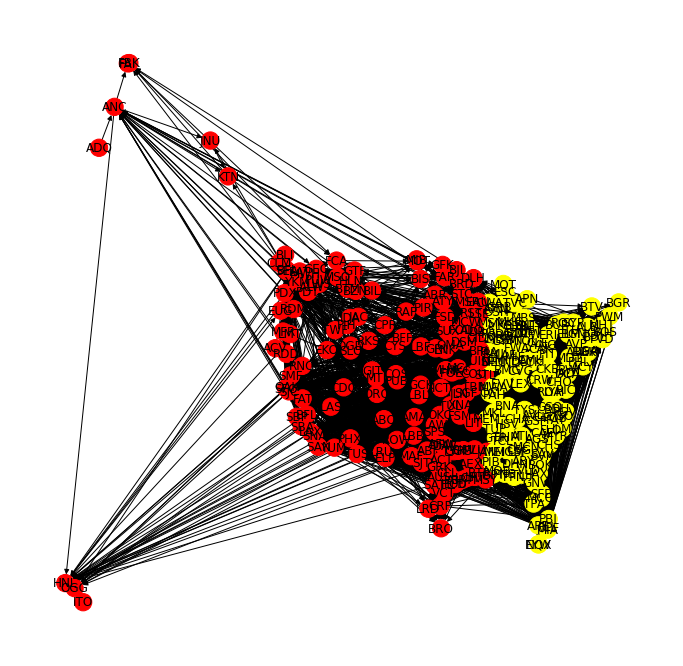

In [34]:
plt.subplots(figsize=(12,12))
color_map = []
for column in east_or_west["east_or_west"]:
    if column == 0:
        color_map.append('red')
    else: 
        color_map.append('yellow')      
nx.draw(network, with_labels=True, arrows=True, pos=position_dict, node_color = color_map)
plt.show()

Finally, I code the necessary part for modularity function of networkx.

In [35]:
east_set = set()
west_set = set()

for index, row in east_or_west.iterrows():
    if row[2] == 1:
        east_set.add(row[0])
    else:
        west_set.add(row[0])
    
east_west_tuple = tuple([east_set,west_set])

In [36]:
import networkx.algorithms.community as nx_comm

nx_comm.modularity(network, communities = east_west_tuple)

0.18008017139420876

I believe this is not a very good partition based on the modularity.

And in the next one, I tried to use Girvan Newman partitions.

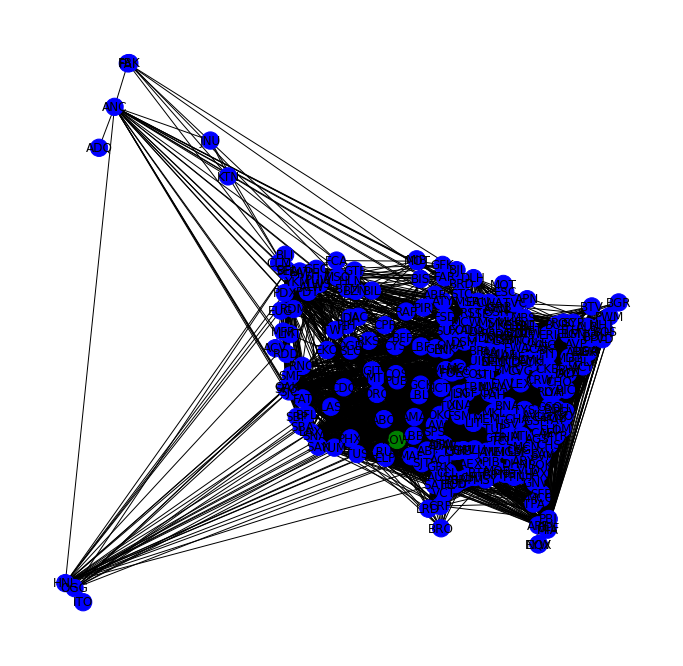

In [37]:
from networkx.algorithms.community.centrality import girvan_newman
communities = girvan_newman(network)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

color_map = []
for node in network:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  
        
plt.subplots(figsize=(12,12))
nx.draw(network, node_color=color_map, with_labels=True, pos=position_dict)
plt.show()

There is only 1 node in the second community. This is strange.

In [38]:
nx_comm.modularity(network, communities = node_groups)

-2.229187601793414e-08

Modularity is very low and negative. This means this network is <b> disassortative</b>, meaning in this network, nodes of low degree are more likely to connect with nodes of a high degree. This finding is inline with our findings with assortativity.

Finally, I will try Louvain heuristices to compute the partition that maximizes the modularity. 

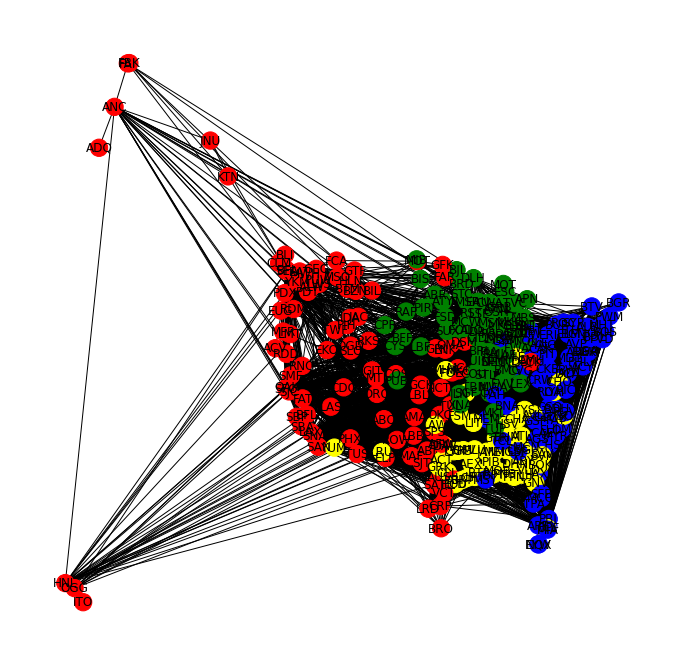

In [39]:
import community.community_louvain

partition = community.community_louvain.best_partition(network)

node_groups = [[],[],[],[],[]]
for key, value in partition.items():
    node_groups[value].append(key)    
    
color_map = []
for node in network:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('red')
    else: 
        color_map.append('yellow')
        
plt.subplots(figsize=(12,12))
nx.draw(network, node_color=color_map, with_labels=True, pos=position_dict)
plt.show()

Now we have very good looking communities. The good part is it looks like it is divided into 4 subsections:
<ol>
    <li>West</li>
    <li>North East</li>
    <li>Midwest</li>
    <li>South Atlantic</li>
</ol>
So, I believe my initial intuition of dividing the USA into east-west would make sense. Finally, we check the modularity.

In [40]:
nx_comm.modularity(network, communities = node_groups)

0.2186180543864705

As expected, modularity is higher than what we have expected when we use Louvain algortihm.

<h4>d) Models</h4>

In this section we will try to compare our network with other well known models to see whether our network can fit into those models so that we can utilize properties of those models.

To generate graphs similar to our model, first we check total number of nodes and edges in our graph.

In [41]:
print(f"Total number of nodes is {network.number_of_nodes()} and edges is {network.number_of_edges()}")

Total number of nodes is 290 and edges is 4736


<h5> i. Erdos-Renyi Random Graph Model</h5>

In this model, graph is chosen uniformly at random from the collection of all graphs which have same node and edge number. For example, if the model is G(3,2), each of the three possible graphs on three vertices and two edges are included with probability 1/3.

In [42]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes(), 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

erdos = gnm_random_graph(290, 4753)

We have created our network and now I will draw it as if it was the actual map of The United States by using Louvain heuristics. This does not give many information, its just for visualization purposes.

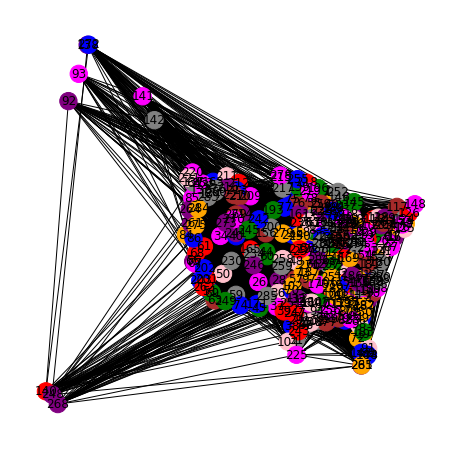

In [43]:
mapping = [*range(0, 290, 1)]

erdos_pos = {}

for (key, value), num in zip(position_dict.items(), mapping):
    erdos_pos[num] = value

partition = community.community_louvain.best_partition(erdos)

node_groups = [[],[],[],[],[],[],[],[],[],[],[]]
for key, value in partition.items():
    node_groups[value].append(key)    
    
color_map = []
for node in erdos:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('red')
    elif node in node_groups[3]: 
        color_map.append('brown')
    elif node in node_groups[4]: 
        color_map.append('gray')
    elif node in node_groups[5]: 
        color_map.append('purple')
    elif node in node_groups[6]: 
        color_map.append('pink')
    elif node in node_groups[7]: 
        color_map.append('orange')
    elif node in node_groups[8]: 
        color_map.append('magenta')
    else: 
        color_map.append('yellow')
        
plt.subplots(figsize=(8,8))
nx.draw(erdos, node_color=color_map, with_labels=True, pos=erdos_pos)
plt.show()

It looks very colorful, very different from our model.

In [44]:
nx_comm.modularity(erdos, communities = node_groups)

0.1347557782832985

Modularity shows that it is different from our model. Now, we can check centralities.

In [45]:
dc = nx.degree_centrality(erdos)
dc = pd.DataFrame.from_dict(dc, orient='index')
dc.rename(columns = {0:'d_cent'}, inplace = True)
dc = dc.sort_values("d_cent", ascending=False)

cc = nx.closeness_centrality(erdos)
cc = pd.DataFrame.from_dict(cc, orient='index')
cc.rename(columns = {0:'c_cent'}, inplace = True)
cc = cc.sort_values("c_cent", ascending=False)

bc = nx.betweenness_centrality(erdos)
bc = pd.DataFrame.from_dict(bc, orient='index')
bc.rename(columns = {0:'b_cent'}, inplace = True)
bc = bc.sort_values("b_cent", ascending=False)

ec = nx.eigenvector_centrality(erdos)
ec = pd.DataFrame.from_dict(ec, orient='index')
ec.rename(columns = {0:'e_cent'}, inplace = True)
ec = ec.sort_values("e_cent", ascending=False)

display_side_by_side([dc.head(10), cc.head(10), bc.head(10), ec.head(10)], ['Degree', 'Closeness', 'Betweenness','Eigenvector'])

Centrality values are very low compared to our network. This is acceptable as in our network we have some very central ones.

Then out of curiosity, I checked the max clique.

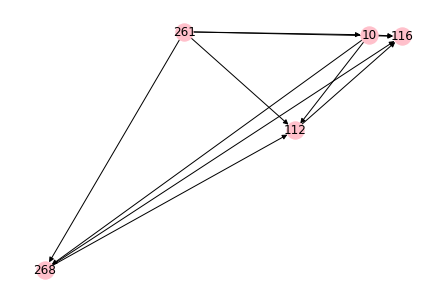

In [46]:
cliques = nx.find_cliques(erdos)
cliques = sorted(cliques, key=lambda item: -len(item))
max_clique = cliques[0]
h = erdos.subgraph(max_clique)
nx.draw(h, with_labels=True, arrows=True, pos=erdos_pos, node_color="pink")

This is the expected result. Normally, in a network, 5 is an acceptable max clique size (when we consider it is 34 in our model!)

Finally, for comparison purposes, I will draw different types of degree distributions.

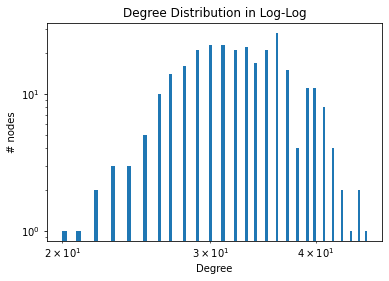

In [47]:
degrees = dict(erdos.degree()).values() 
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree Distribution in Log-Log')
plt.xscale('log')
plt.yscale('log')
plt.show()

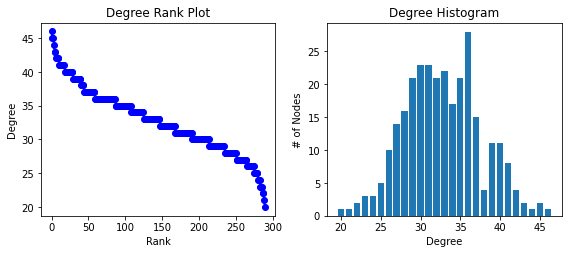

In [48]:
degree_sequence = sorted((d for n, d in erdos.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree Histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

When we look at log-log scale, rank plot and degree histogram, Erdos-Renyi model looks like a normal distribution. In our network, degree distribution was highly asymmetric.

In my conclusion, I believe our model is far-away from being an Erdos-Renyi model.

<h5> ii. Watts-Strogatz Small-World Model</h5>

The Watts–Strogatz model is a random graph generation model that produces graphs with small-world properties, including short average path lengths and high clustering. I have selected the k as the mean degree of the network and tried some probabilities, 0.1 yielded the network that is the most similar to my network.

In [49]:
degrees_.mean()

degrees    32.662069
dtype: float64

In [50]:
def watts_strogatz_graph(N, k, p):
    G = nx.cycle_graph(N)

    for n in G.nodes():
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)

    for u, v in list(G.edges()):
        if random.random() < p:
            not_neighbors = set(G.nodes()) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

watts = watts_strogatz_graph(290, 32, 0.1)

We have created our network and now let's check total nodes and edges.

In [51]:
watts.number_of_nodes()

290

In [52]:
watts.number_of_edges()

4640

As it has very similar node and edge amount with my network, now I will draw it as if it was the actual map of The United States by using Louvain heuristics. This does not give many information, its just for visualization purposes.

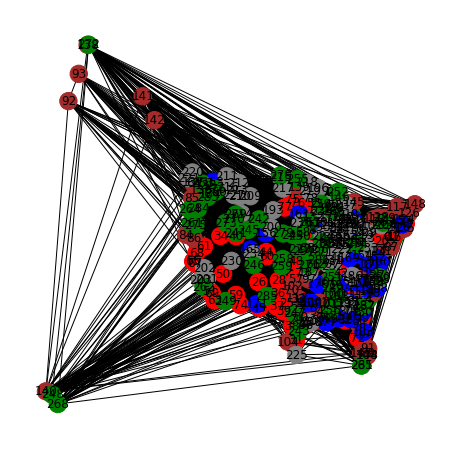

In [53]:
mapping = [*range(0, 290, 1)]

watts_pos = {}

for (key, value), num in zip(position_dict.items(), mapping):
    watts_pos[num] = value

partition = community.community_louvain.best_partition(watts)

node_groups = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for key, value in partition.items():
    node_groups[value].append(key)    
    
color_map = []
for node in watts:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('red')
    elif node in node_groups[3]: 
        color_map.append('brown')
    elif node in node_groups[4]: 
        color_map.append('gray')
    elif node in node_groups[5]: 
        color_map.append('purple')
    elif node in node_groups[6]: 
        color_map.append('pink')
    else:
        color_map.append('aliceblue')
        
plt.subplots(figsize=(8,8))
nx.draw(watts, node_color=color_map, with_labels=True, pos=watts_pos)
plt.show()

Now it looks interesting, a little close to my model.

In [54]:
nx_comm.modularity(watts, communities = node_groups)

0.5750655144545185

However, the things is, our modularity is very high. This is expected because with Watts-Strogatz model, communities are considered. Now, we can check centralities.

In [55]:
dc = nx.degree_centrality(watts)
dc = pd.DataFrame.from_dict(dc, orient='index')
dc.rename(columns = {0:'d_cent'}, inplace = True)
dc = dc.sort_values("d_cent", ascending=False)

cc = nx.closeness_centrality(watts)
cc = pd.DataFrame.from_dict(cc, orient='index')
cc.rename(columns = {0:'c_cent'}, inplace = True)
cc = cc.sort_values("c_cent", ascending=False)

bc = nx.betweenness_centrality(watts)
bc = pd.DataFrame.from_dict(bc, orient='index')
bc.rename(columns = {0:'b_cent'}, inplace = True)
bc = bc.sort_values("b_cent", ascending=False)

ec = nx.eigenvector_centrality(watts, max_iter=500)
ec = pd.DataFrame.from_dict(ec, orient='index')
ec.rename(columns = {0:'e_cent'}, inplace = True)
ec = ec.sort_values("e_cent", ascending=False)

display_side_by_side([dc.head(10), cc.head(10), bc.head(10), ec.head(10)], ['Degree', 'Closeness', 'Betweenness','Eigenvector'])

Now the centralities look similar to my model.

Then, again, out of curiosity, I checked the max clique.

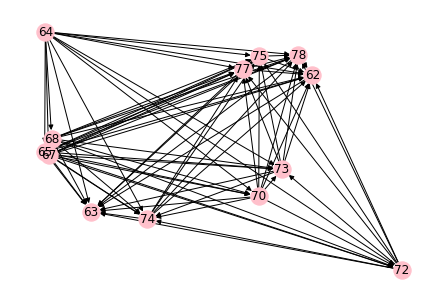

In [56]:
cliques = nx.find_cliques(watts)
cliques = sorted(cliques, key=lambda item: -len(item))
max_clique = cliques[0]
h = watts.subgraph(max_clique)
nx.draw(h, with_labels=True, arrows=True, pos=watts_pos, node_color="pink")

We have a high amount of clique here.

Finally, for comparison purposes, I will draw different types of degree distributions.

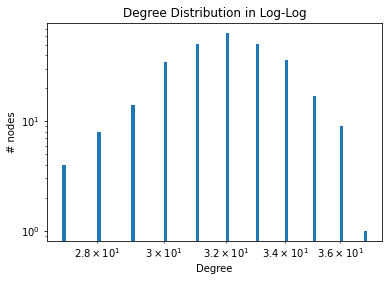

In [57]:
degrees = dict(watts.degree()).values() 
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree Distribution in Log-Log')
plt.xscale('log')
plt.yscale('log')
plt.show()

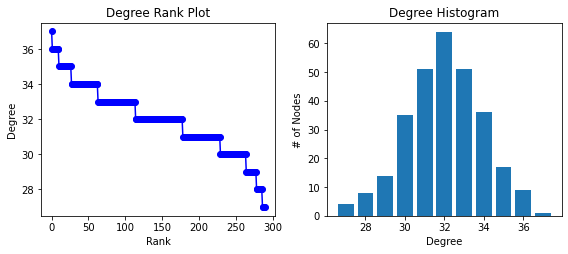

In [58]:
degree_sequence = sorted((d for n, d in watts.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree Histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

Its still normally distributed, we could not improve it too much.

In conclusion, I believe Watts-Strogatz model looks somewhat similar to my network.

<h5> iii. Barabasi Albert Model</h5>

Finally, I will have a look at how a Barabasi Albert fits to my network. The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism.

In [59]:
def barabasi_albert_graph(N, m):
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        
        new_neighbors = []
        possible_neighbors = list(G.nodes())
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

barabasi = barabasi_albert_graph(290, 15)

We have created our network and now let's check total nodes and edges.

In [60]:
barabasi.number_of_nodes()

290

In [61]:
barabasi.number_of_edges()

4230

As it has very similar node and edge amount with my network, now I will draw it as if it was the actual map of The United States by using Louvain heuristics. This does not give many information, its just for visualization purposes.

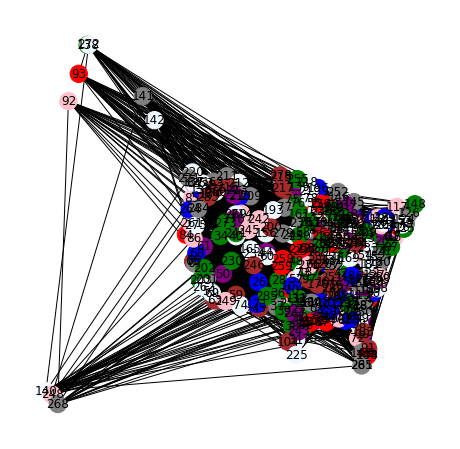

In [62]:
mapping = [*range(0, 290, 1)]

barabasi_pos = {}

for (key, value), num in zip(position_dict.items(), mapping):
    barabasi_pos[num] = value

partition = community.community_louvain.best_partition(barabasi)

node_groups = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for key, value in partition.items():
    node_groups[value].append(key)    
    
color_map = []
for node in barabasi:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]: 
        color_map.append('green')
    elif node in node_groups[2]: 
        color_map.append('red')
    elif node in node_groups[3]: 
        color_map.append('brown')
    elif node in node_groups[4]: 
        color_map.append('gray')
    elif node in node_groups[5]: 
        color_map.append('purple')
    elif node in node_groups[6]: 
        color_map.append('pink')
    else:
        color_map.append('aliceblue')
        
plt.subplots(figsize=(8,8))
nx.draw(barabasi, node_color=color_map, with_labels=True, pos=barabasi_pos)
plt.show()

In [63]:
nx_comm.modularity(barabasi, communities = node_groups)

0.13460067959917063

It quite looks similar to Erdos-Renyi, a low modularity. Now, we proceed with centralities.

In [64]:
dc = nx.degree_centrality(barabasi)
dc = pd.DataFrame.from_dict(dc, orient='index')
dc.rename(columns = {0:'d_cent'}, inplace = True)
dc = dc.sort_values("d_cent", ascending=False)

cc = nx.closeness_centrality(barabasi)
cc = pd.DataFrame.from_dict(cc, orient='index')
cc.rename(columns = {0:'c_cent'}, inplace = True)
cc = cc.sort_values("c_cent", ascending=False)

bc = nx.betweenness_centrality(barabasi)
bc = pd.DataFrame.from_dict(bc, orient='index')
bc.rename(columns = {0:'b_cent'}, inplace = True)
bc = bc.sort_values("b_cent", ascending=False)

ec = nx.eigenvector_centrality(barabasi, max_iter=500)
ec = pd.DataFrame.from_dict(ec, orient='index')
ec.rename(columns = {0:'e_cent'}, inplace = True)
ec = ec.sort_values("e_cent", ascending=False)

display_side_by_side([dc.head(10), cc.head(10), bc.head(10), ec.head(10)], ['Degree', 'Closeness', 'Betweenness','Eigenvector'])

Centralities look quite high, even higher than our original network.

Then, again, out of curiosity, I checked the max clique.

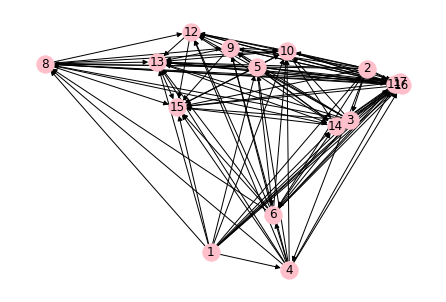

In [65]:
cliques = nx.find_cliques(barabasi)
cliques = sorted(cliques, key=lambda item: -len(item))
max_clique = cliques[0]
h = watts.subgraph(max_clique)
nx.draw(h, with_labels=True, arrows=True, pos=watts_pos, node_color="pink")

Again, we have relatively a big clique. 

Finally, for comparison purposes, I will draw different types of degree distributions.

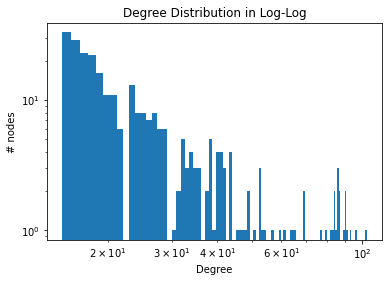

In [66]:
degrees = dict(barabasi.degree()).values() 
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree Distribution in Log-Log')
plt.xscale('log')
plt.yscale('log')
plt.show()

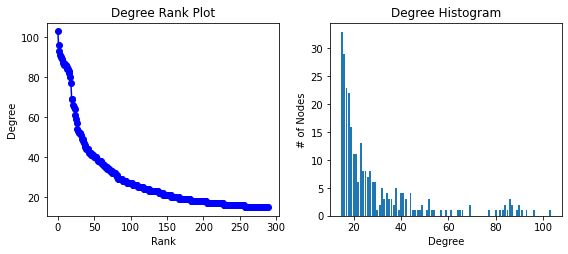

In [67]:
degree_sequence = sorted((d for n, d in barabasi.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree Histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

Now it looks quite the same with our model.

Because of the similarities in degree distribution and centralities, I believe my network is quite similar to a <b> Barabasi Albert model</b>. As their centralities is similar but degree distributions are very different, I believe my network is just a little bit similar with <b>Watts-Strogatz model</b>. And finally I believe my model is very different from <b>Erdos-Renyi model</b>.

<h4>e) Dynamic Models</h4>

Finally, I will add some dynamism to my model with 2 different cases. One will be a simulation for an epidemic. Other one will be a surprise game.

<h5> i. Epidemic Simulation</h5>

Here I will create a simulation for epidemic in the United States airport. I will create a big class and what each function of the class does is given in as the descriptions in correspoding functions. I will here talk about the simulations and assumptions I made.

This simulation assumes there are 290 domestic airports in the USA. Due to a recent pandemic started in the USA, USA only allows domestic flights, no international ones. 

In creating a simulation, you should first create a Simulation instance. Then, you should use start function to start the simulation. This has 4 parameters that the user can change:
<ul> 
    <li>start: In how many airports will the epidemic start. This has a probability distribution as well. The higher degree an airport has, the higher likely it will selected as the source of epidemic. Default value is 3. </li>
    <li>recovery: After a certain amount of time, things become normal and airport recovers. After that, there is no possibility of becoming sick again.  Default value is 3.</li>
    <li>diffusion: How likely an airport that has the disease spreads the virus to the connected airports. Default value is 0.2. </li>
    <li>death: How likely the airport is dead (or shut down due to extremely bad conditions). Default value is 0.1. </li>
</ul>

Some limitations of the model:
<ul> 
    <li>Model does not assume population of cities or amount of passengers carried between airports. For simplicity, it only takes connections into consideration. </li>
    <li>Again, for simplicity purposes, all distributions are very simple. It is almost always binary. Better applications with other types of distributions can be tried. </li>
</ul>

In [89]:
from random import choices
import random

class Epidemic:
    '''
    Here I created DataFrame from our network because working with pandas is
    much easier than working with networkx
    '''
    network = network.copy()
    net_df = {node:val for (node, val) in network.degree()}
    net_df = pd.DataFrame.from_dict(net_df , orient="index")
    net_df.columns = ['degree']
    net_df["node"] = net_df.index
    net_df.reset_index(inplace=True)
    net_df = net_df.drop(columns=['index'])
    net_df["degree_perc"] = net_df["degree"]/sum(net_df["degree"])
    net_df["status"] = "Healthy"
    net_df["year"] = 0 #For counting years being sick
    year = 1 #For counting total years passed
    sis_model = [] #For drawing SIS model
    
    start = 3
    recovery = 3
    diffusion = 0.2
    death = 0.1
    
    def __init__(self):
        pass
    
    def start(self, start=3, recovery=3, diffusion=0.2, death=0.1):
        '''
        Here, the variables are initialized.
        '''
        self.start = start
        self.recovery = recovery
        self.diffusion = diffusion
        self.death = death
        
        '''
        At first, I randomly selected "start" amount of nodes and made them
        random.
        '''
        sicks = choices(self.net_df["node"], k=start, weights=self.net_df["degree_perc"])
        self.net_df.loc[self.net_df['node'].isin(sicks), 'status'] = 'Sick'
        self.drawGraph() 
        print(f"Year {self.year} is completed")
        self.can_start = False
        
    def advance(self):
        '''
        After start, the first thing I do is to pass 1 year on sick nodes.
        '''
        sicks = list(self.net_df.loc[self.net_df['status'] == "Sick", 'node'])
        self.net_df.loc[self.net_df['node'].isin(sicks), 'year'] += 1
        
        '''
        Then, I check whether any of the airports fully recovers.
        '''
        recovers = self.net_df.loc[self.net_df['year'] == self.recovery, "node"]
        self.net_df.loc[self.net_df['node'].isin(recovers), 'status'] = 'Recovered'
        
        '''
        Then, I check whether the airport dies (or shuts down).
        '''
        for i in sicks:
            if random.random() < self.death:
                self.net_df.loc[self.net_df['node']==i, 'status'] = 'Deceased'
        '''
        Then, I simulate the diffusion process.
        '''        
        possible_sicks =  [v for (k, v) in self.network.edges(sicks)]
        for i in possible_sicks:
            if random.random() < self.diffusion:
                self.net_df.loc[(self.net_df['node']==i) & (self.net_df['status'] == 'Healthy'), 'status'] = 'Sick'
        
        self.drawGraph()
        
        self.year += 1
        print(f"Year {self.year} is completed")
        
    def drawGraph(self):
        '''
        This function draws the network. It is called automatically by each
        start and advance.
        '''
        node_groups = self.net_df["status"]
        
        color_map = []
        for node in node_groups:
            if node == "Healthy":
                color_map.append('green')
            elif node == "Sick": 
                color_map.append('red')  
            elif node == "Recovered": 
                color_map.append('blue')
            elif node == "Deceased": 
                color_map.append('gray')

        self.sis_model.append(color_map.count("red") + color_map.count("blue") + color_map.count("gray"))        
        
        plt.subplots(figsize=(12,12))
        nx.draw(network, node_color=color_map, with_labels=True, pos=position_dict)
        plt.show()
        
    def sisModel(self):
        '''
        This function is for drawing SIS Model.
        '''
        normalized = [x / 290 for x in self.sis_model]
        plt.subplots(figsize=(8,8))
        plt.axhline(y=1, color='r', linestyle='-')
        plt.plot(normalized)
        plt.title("SIS Model")
        plt.show()
        
    def statistics(self):
        '''
        This function is for showing statistics when it is called.
        '''
        values = dict(self.net_df["status"].value_counts())
        for k, v in values.items():
            print(f'There are {v} {k} airports.')

<h3>An example simulation. 

First, I create an instance.

In [90]:
simulation = Epidemic()

Then, I start my simulation and I'd like to change some parameters. Please be careful to run this cell only once.

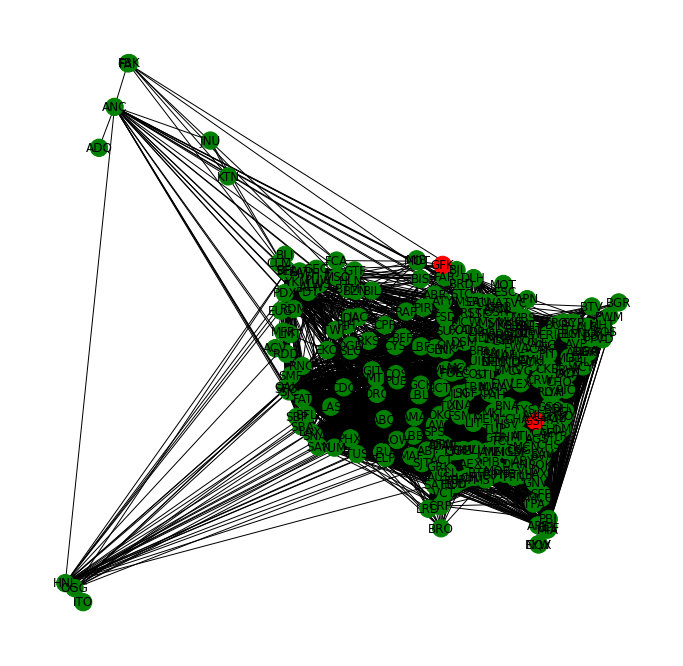

Year 1 is completed


In [91]:
simulation.start(start=2, recovery=4)

Then, you can advance the model as many times you want. Here, I will show some shapshots of year 2 and 14.

<h4> Year 2

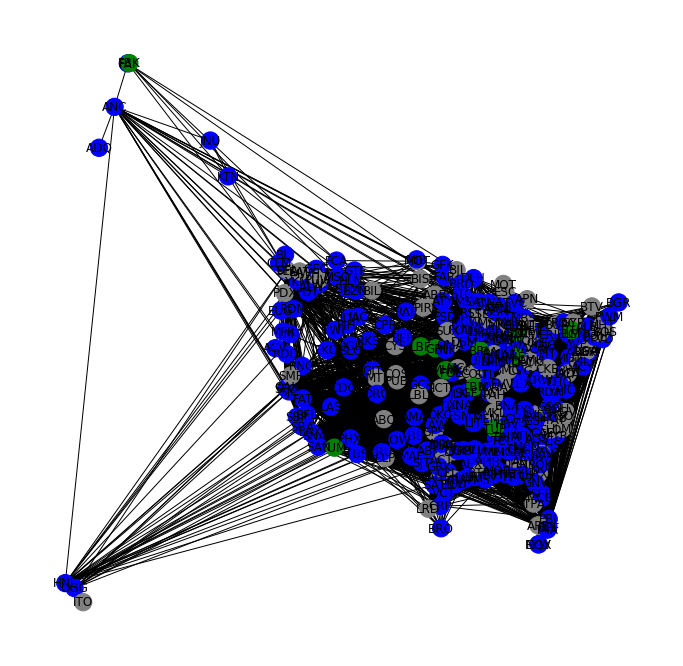

Year 12 is completed


In [82]:
simulation.advance()

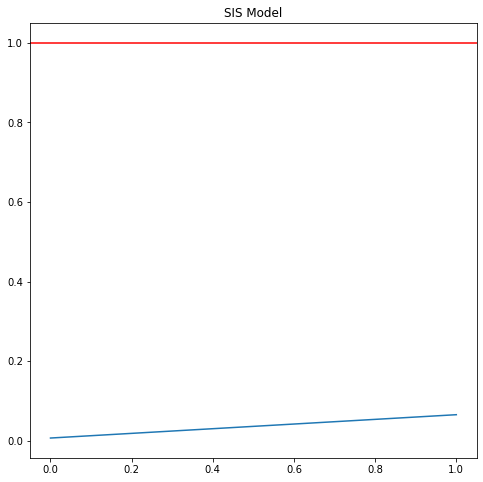

In [71]:
simulation.sisModel()

In [72]:
simulation.statistics()

There are 271 Healthy airports.
There are 19 Sick airports.


<h4> Year 14

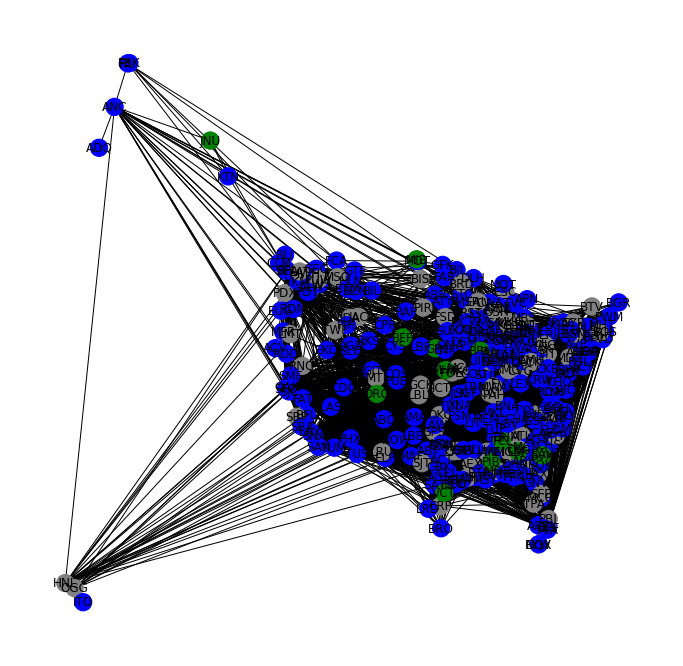

Year 14 is completed


In [103]:
simulation.advance()

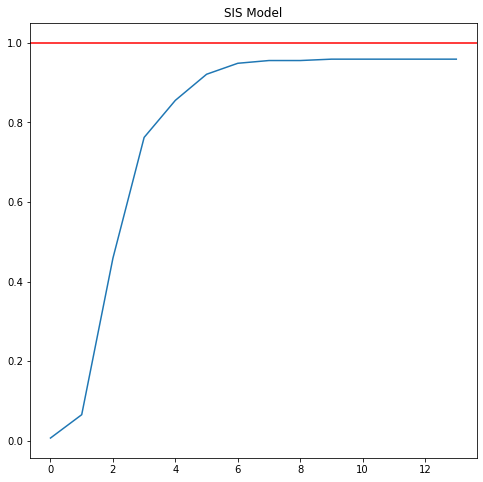

In [104]:
simulation.sisModel()

In [105]:
simulation.statistics()

There are 203 Recovered airports.
There are 75 Deceased airports.
There are 12 Healthy airports.


As we can see, it follows a good SIS model. Starts out quickly, then slowly the epidemic dies out.

Now the question is, what we can infer from this model.

<ul>
    <li>It is obvious to notice that, if we increase number of starting nodes or choose nodes with higher degrees as epidemic sources, we will have a worse situation. </li>
    <li>With this model (of course with an improved one), we can compare how different types of viruses will affect the airport system of the USA. A virus can be less deadlier but easy to spread and other one can be very fatal but hard to spread. We can simulate them enough times to compare the results.</li>
</ul>

<h5> ii. Hunter Game</h5>

Here I will create a simulation game for simulatin a random-walk game.

This game is about you running away from bounty hunters and predators in the USA. By default, there are 10 of them, however you can increase this number as much as you can. You should use domestic airports to run away from them.

Rules are simple. You start the game with two basic parameters:
<ul> 
    <li>max_rounds: After how much of successful escapes you will be safe. The default is 20 and if you want to increase the difficulty of the game, you can increase it further. </li>
    <li>hunters: How many hunter you will have. Default is 10. Also, for the first 10 hunters & predators, there are some surprises.</li>
</ul>
    
Game randomly assigns you to an airport. Then, you can go to any other airports that is connected to your current one. Also, all of the hunters & predators also move with you. However, to make things harder, you will make your move first. So, if you fly to one of them, you will be dead. Also, after your move, if they move to your airport, you will be dead again.

Some limitations of the game:
<ul> 
    <li>Hunters and predators are totally randomly moving. They may even draw unmeaningful circles sometimes. A better approach would be hunters and predators may tend to use airports with higher degrees. </li>
    <li>I assume all distances are same. Going from Alaska to New York is equal time as going from Massachusets to New York. </li>
</ul>

In [76]:
from random import choices
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class HunterGame:
    '''
    Copying network and initalizating parameters.
    '''
    network = network.copy()
    nodes = list(network.nodes())
    degrees = {node:val for (node, val) in network.degree()}
    degrees = pd.DataFrame.from_dict(degrees, orient="index")
    
    moves = []
    point = 0
    
    rounds = 0
    not_caught = True #If it is caught or not
    success = False #If successfully escapes
    
    '''
    Creates player & hunters.
    '''
    def __init__(self, max_rounds = 20, hunters=10):
        self.max_rounds = max_rounds
        self.hunters = hunters
        self.moves = [[] for i in range(hunters+1)]
    
    '''
    Randomly assigns people to places.
    '''
    def start(self):
        start_points = random.choices(self.nodes, k=self.hunters+1)
        for i in range(len(self.moves)):
            self.moves[i].append(start_points[i])
    
    '''
    For people to make their move. Also, it makes hunters to move.
    '''
    def makeMove(self):
        if((self.not_caught) & (not self.success)):
            possible_moves = [[] for i in range(self.hunters+1)]

            for i in range(self.hunters+1):
                neighbors = [n for n in network.neighbors(self.moves[i][-1])]
                possible_moves[i].append(neighbors)
            
            possible_degrees = []

            for i in possible_moves[0][0]:
                a = self.degrees.loc[self.degrees.index==i, 0].item()
                possible_degrees.append(a)

            zip_iterator = zip(possible_moves[0][0], possible_degrees)

            possible_dictionary = dict(zip_iterator)

            sorted_possible_moves = {k: v for k, v in sorted(possible_dictionary.items(), key=lambda item: item[1])}

            for i in range(self.hunters+1):
                if(i==0):
                    print(f"You can go {sorted_possible_moves}")
                    while True:
                        x = str(input())
                        if (x in possible_moves[0][0]):
                            
                            self.rounds += 1
                            self.moves[i].append(x)
                            self.endCheck()
                            if(self.not_caught):
                                print(f"You successfully went to {x}.")
                                print(f"You need to escape {self.max_rounds - self.rounds} more years.")
                                self.point += self.degrees.loc[self.degrees.index==self.moves[0][-1], 0].item()
                                print(f"Total points so far: {self.point}")
                            break
                        else:
                            print("Please try again.")
                else:
                    select = random.choice(possible_moves[i][0])
                    self.moves[i].append(select)
                    while self.not_caught:
                        self.endCheck()
                        break
        else:
            if(self.success):
                print("You have successfully run away from the hunters!")
                print(f"Your final points: {self.point}")
            else:
                print("You cannot move, you are about to die!")
                print(f"Your final points: {self.point}")
    
    '''
    After each move, we check whether game is finished or not.
    '''
    def endCheck(self):
        for i in range(1, self.hunters+1):
            if self.moves[0][-1] == self.moves[i][-1]:
                self.caught(i)
                break
        
        if self.rounds == 21:
            print("You have successfully ran away from the bounty hunters!")
            self.success = True
    
    '''
    If the player is caught, this runs.
    '''
    def caught(self, by):
        self.not_caught = False       
        if by == 1:
            print("You have been caught by Boba Fett!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('boba_fett.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 2:
            print("You have been caught by Django!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('django.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 3:
            print("You have been caught by Blondie!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('blondie.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 4:
            print("You have been eaten by Alien!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('alien.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 5:
            print("You have been shot by Jules Winfield!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('jules.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 6:
            print("You have been terminated by Terminator!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('terminator.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 7:
            print("You have been shattered by Neo!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('neo.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 8:
            print("You have been found and killed by Bryan Mills!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('taken.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 9:
            print("You have been caught by Hans Landa!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('hans.jpeg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        elif by == 10:
            print("You have been detected by Sherlock Holmes!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('sherlock.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            print("You have been taken as prison by a Stormtrooper!")  
            print(f"Your final points: {self.point}")
            img = mpimg.imread('stormtrooper.jpg')
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.show()
    
    '''
    In any time of the journey, player can draw current journey.
    '''
    def drawJourney(self):
        self_road = self.moves[0]
        tuples = []
        for first, second in zip(self_road, self_road[1:]):
            tuples.append([first,second])
        tuples = [tuple(x) for x in tuples]
        reverses = [(tupl[1], tupl[0]) for tupl in tuples]
        tuples = tuples + reverses
        edges =  [(k, v) for (k, v) in self.network.edges()]
        
        edge_colors = ['red' if (x not in tuples) else 'black' for x in edges]
        
        nodes = list(set([tupl[1] for tupl in tuples]))
        
        plt.subplots(figsize=(8,8))
        nx.draw(network, nodelist = nodes, edgelist=tuples, edge_color=edge_colors, with_labels=True, pos=position_dict)
        plt.show()

<h3>An example simulation. 

I initialize the game.

In [77]:
game = HunterGame()

I start with default parameters of 20 rounds with 10 hunters. Please run this function only once.

In [78]:
game.start()

I playing the game by continuously rerunning this cell. If you write a wrong airport name, it will ask you to write again.

You can go {'BMG': 2, 'UIN': 3, 'OSH': 4, 'PUB': 9, 'CWA': 11, 'JAC': 11, 'SUX': 11, 'DBQ': 12, 'ATW': 16, 'GJT': 17, 'BMI': 18, 'AZO': 19, 'LSE': 20, 'TVC': 21, 'BIL': 22, 'RST': 22, 'BGR': 23, 'CRW': 23, 'CMI': 24, 'LNK': 24, 'AGS': 25, 'CYS': 25, 'ERI': 25, 'LRD': 25, 'ROA': 25, 'BTV': 26, 'ANC': 27, 'MGM': 27, 'SPI': 27, 'HNL': 28, 'FAR': 28, 'CHA': 31, 'RFD': 31, 'EVV': 33, 'MYR': 33, 'XNA': 33, 'FSD': 34, 'MAF': 35, 'GEG': 36, 'GRB': 36, 'LAN': 36, 'SGF': 36, 'TOL': 36, 'PWM': 37, 'RNO': 37, 'CID': 38, 'DLH': 38, 'LEX': 38, 'PIA': 38, 'AEX': 39, 'HSV': 39, 'LBB': 39, 'MBS': 40, 'SPS': 40, 'SBN': 42, 'BTR': 43, 'MSN': 43, 'CRP': 43, 'ABE': 44, 'AMA': 45, 'CAK': 45, 'SMF': 45, 'ELP': 47, 'SNA': 47, 'MHT': 48, 'CHS': 48, 'ROC': 48, 'TUS': 48, 'MDT': 51, 'SYR': 51, 'ICT': 52, 'ALB': 53, 'LIT': 53, 'OAK': 53, 'JAN': 54, 'FWA': 55, 'ABI': 55, 'PBI': 55, 'SHV': 55, 'DAL': 56, 'CAE': 56, 'PVD': 56, 'GRR': 58, 'COS': 59, 'GSP': 59, 'BUF': 61, 'GSO': 61, 'JAX': 61, 'TYS': 61, 'SJC': 63, 'D

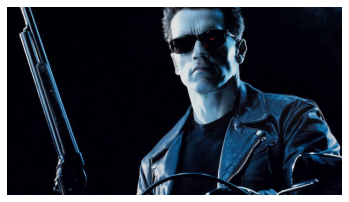

In [91]:
game.makeMove()

After game is completed (or in the middle of the game), with the function below, I can always draw my current journey. I also tried to draw everyone's journey but graph was getting so complicated, I only draw the player's journey.

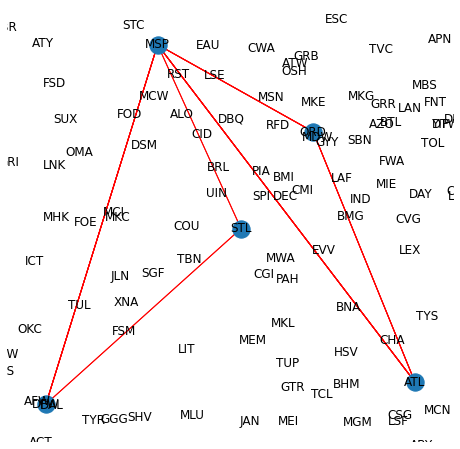

In [92]:
game.drawJourney()

Now the question is, what we can infer from this model.

<ul>
    <li>This model can be used to understand some Game Theory applications because here the more risk you take, the more you get the points but you are more likely to be killed. </li>
</ul>